This is a minor refactoring of the Gaussian Process Kernel from 
https://github.com/Ryan-Rhys/The-Photoswitch-Dataset/blob/master/examples/gp_regression_on_molecules.ipynb

This refactoring mostly enables pickling support for saving models and generates a combined Tanimoto+Descriptor kernel.

To test this, we examine how to predict the number of heavy atoms in a molecule using both methods.

Requirements:
 
*n.b.* if you are on ARM, you probably want to use conda and create an environment:

```
   conda create -n test-ugm-talk python=3.10 grpcio jupyter
```

In [2]:
%pip install rdkit
%pip install scikit-learn
%pip install pip install "descriptastorus>=2.6.0"
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install "gpflow>=2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.3/445.3 kB 8.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 29.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 13.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 8.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.7 MB/s eta 0:0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 6.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import gpflow
from gpflow.mean_functions import Constant
from sklearn.preprocessing import StandardScaler
from gpflow.utilities import positive
from gpflow.utilities.ops import broadcasting_elementwise
import tensorflow as tf
import numpy as np
from scipy.sparse import csr_matrix
import operator
import logging
import io, pathlib, tempfile, tarfile, os

/Users/bkelley/miniconda3/envs/test-ugm-talk/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/bkelley/miniconda3/envs/test-ugm-talk/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


In [5]:
print(f"Using gpflow version {gpflow.__version__}")

Using gpflow version 2.6.3


Utility functions for saving the models

In [6]:
def directory_to_bytes(dirname):
    """Archive a whole directory to a stream of bytes using the tarfile package
      n.b. because this uses chdir, it is not generally thread safe
    """
    bio = io.BytesIO()
    path = os.path.abspath(os.getcwd())
    try:
        parent, directory = os.path.split(dirname)
        os.chdir(parent)
        with tarfile.open(fileobj=bio, mode='w:bz2') as tar:
            tar.add(directory, recursive=True)
        return bio.getvalue()
    finally:
        os.chdir(path)

def directory_from_bytes(dirname, tarball):
    """Restore a directory from bytes
          n.b. because this uses chdir, it is not generally thread safe
    """
    bio = io.BytesIO(tarball)
    path = os.path.abspath(os.getcwd())
    try:
        os.chdir(dirname)

        with tarfile.open(fileobj=bio, mode='r:bz2') as tar:
            tar.extractall(dirname)
            directories = os.listdir(dirname)
            assert len(directories) == 1
            return os.path.join(dirname, directories[0])
    finally:
        os.chdir(path)


GPFLow Tanimoto kernel (from Ryan-Rhys)

In [7]:
class Tanimoto(gpflow.kernels.Kernel):
    def __init__(self, active_dims=None):
        super().__init__(active_dims=active_dims)
        # We constrain the value of the kernel variance to be positive when it's being optimised
        self.variance = gpflow.Parameter(1.0, transform=positive())

    def K(self, X, X2=None):
        """
        Compute the Tanimoto kernel matrix σ² * ((<x, y>) / (||x||^2 + ||y||^2 - <x, y>))
        
         X is a matrix of fingerprints
          | mol_0_bit_0 mol_0_bit_1 ...  |
          | mol_1_bit_0 mol_1_bit_1 ...  |
           
        :param X: N x D array
        :param X2: M x D array. If None, compute the N x N kernel matrix for X.
        :return: The kernel matrix of dimension N x M
        """
        if X2 is None:
            X2 = X

        Xs = tf.reduce_sum(tf.square(X), axis=-1)  # Squared L2-norm of X, 
                                                   # ends up being |bits_set_in_mol_0 bits_set_in_mol_1|
        X2s = tf.reduce_sum(tf.square(X2), axis=-1)  # Squared L2-norm of X2
                                                     # ends up being |bits_set_in_mol_0 bits_set_in_mol_1|

        outer_product = tf.tensordot(X, X2, [[-1], [-1]])  # outer product of the matrices X and X2
             # ends up being a symmetric matrix where entry m_i_j is the number of bits in common
             #  between molecule_i and molecule_2

        # Analogue of denominator in Tanimoto formula
        # for more details of broadcasting_elementwise, see:  https://deeplizard.com/learn/video/QscEWm0QTRY
        denominator = -outer_product + broadcasting_elementwise(tf.add, Xs, X2s)

        kernel = self.variance * outer_product / denominator
        logging.debug("%s kernel shape: %r", self.__class__.__name__, kernel.shape)
        return kernel

    def K_diag(self, X):
        """
        Compute the diagonal of the N x N kernel matrix of X
        :param X: N x D array
        :return: N x 1 array
        """
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))


Here we make a simple scipy learn like fitter:

```
fitter = TanimotoGP(Tanimoto)
fitter.fit(X)
preds, variances = fitter.predict(X)
```

In [8]:
class TanimotoGP:
    def __init__(self, kernel=None, maxiter=100):
        self.kernel = kernel or Tanimoto()
        self.maxiter = maxiter
        self.model = None                 # The GPFlowModel
        self.y_scaler = StandardScaler()  # the scaler to use
        self.shape = None                 # the shape of the training data
        
    def objective_closure(self):
        """Optimize the model to reduce the marginal likelihood
        This is the probability of generating the prediction (and sample) from the prior
        observed data data"""
        return -self.m.log_marginal_likelihood()

    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        self.shape = (None, X_train.shape[1])
        y_train = np.array(y_train)
        y_train_scaled = self.y_scaler.fit_transform(y_train.reshape(-1, 1))
        self.m = gpflow.models.GPR(data=(X_train.astype(np.float64), y_train_scaled),
                                   mean_function=Constant(np.mean(y_train_scaled)),
                                   kernel=self.kernel,
                                   noise_variance=1)
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.objective_closure, 
                     self.m.trainable_variables,
                     options=dict(maxiter=self.maxiter))
        self.last_var = None
        
    def predict(self, X_test):
        """Returns predictions and variances"""
        X_test = np.array(X_test)
        if hasattr(self.m, 'predict_f_compiled'):
            predict_f = self.m.predict_f_compiled
        else:
            predict_f= self.m.predict_f
        mu, var = predict_f(X_test.astype(np.float64))
        y_pred = self.y_scaler.inverse_transform(mu)
        y_var = self.y_scaler.scale_ * var  # need to also rescale the variances!
        return y_pred.flatten(), y_var
    
    def __getstate__(self):
        """Allow pickling of the model"""
        assert self.shape
        d = {}
        d.update(self.__dict__)
        gpflow.utilities.freeze(self.m)
        self.m.predict_f_compiled = tf.function(
            self.m.predict_f, input_signature=[tf.TensorSpec(shape=self.shape, dtype=tf.float64)]
        )

        with tempfile.TemporaryDirectory() as tmpdirname:
            if self.m:
                tf.saved_model.save(self.m, tmpdirname)
            else:
                tf.saved_model.save(self.kernel, tmpdirname)
            
            bytes = directory_to_bytes(tmpdirname)
        
        if self.m:
            d['m'] = bytes
            d['kernel'] = None # fit can't be called again?
        else:
            d['m'] = None
            d['kernel'] = bytes

        d['last_var'] = None
        return d
    
    def __setstate__(self, d):
        """Allow depickling of the model"""
        self.__dict__ = d
        with tempfile.TemporaryDirectory() as tmpdirname:
            if d['m']:
                dirname = directory_from_bytes(tmpdirname, d['m'])
                self.m = tf.saved_model.load(dirname)
                self.kernel = self.m.kernel
            else:
                dirname = directory_from_bytes(tmpdirname, d['kernel'])
                self.kernel = tf.saved_model.load(dirname)
                self.m = None


Let's give it a try!
==============
Let's try and predict number of heavy atoms based on the fingerprint counts, note that this probably won't work too well since this isn't captured well by binary fingerprints.

In [9]:
from descriptastorus import descriptors
featgen = descriptors.MakeGenerator(["Morgan3"])
smiles = ["C"*(i+1) for i in range(0,100)]
mols_processed, features = featgen.processSmiles(smiles)
Y = list(range(1,101))

In [10]:
fitter = TanimotoGP(maxiter=1000)
fitter.fit(features, Y)

/Users/bkelley/miniconda3/envs/test-ugm-talk/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2022-10-19 11:08:38.988940: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
preds, variances = fitter.predict(features)

We need to convert the variance into a 95% confidence interval

In [12]:
errors = 1.96*(np.abs(variances)**0.5)

In [13]:
from matplotlib import pyplot as plt

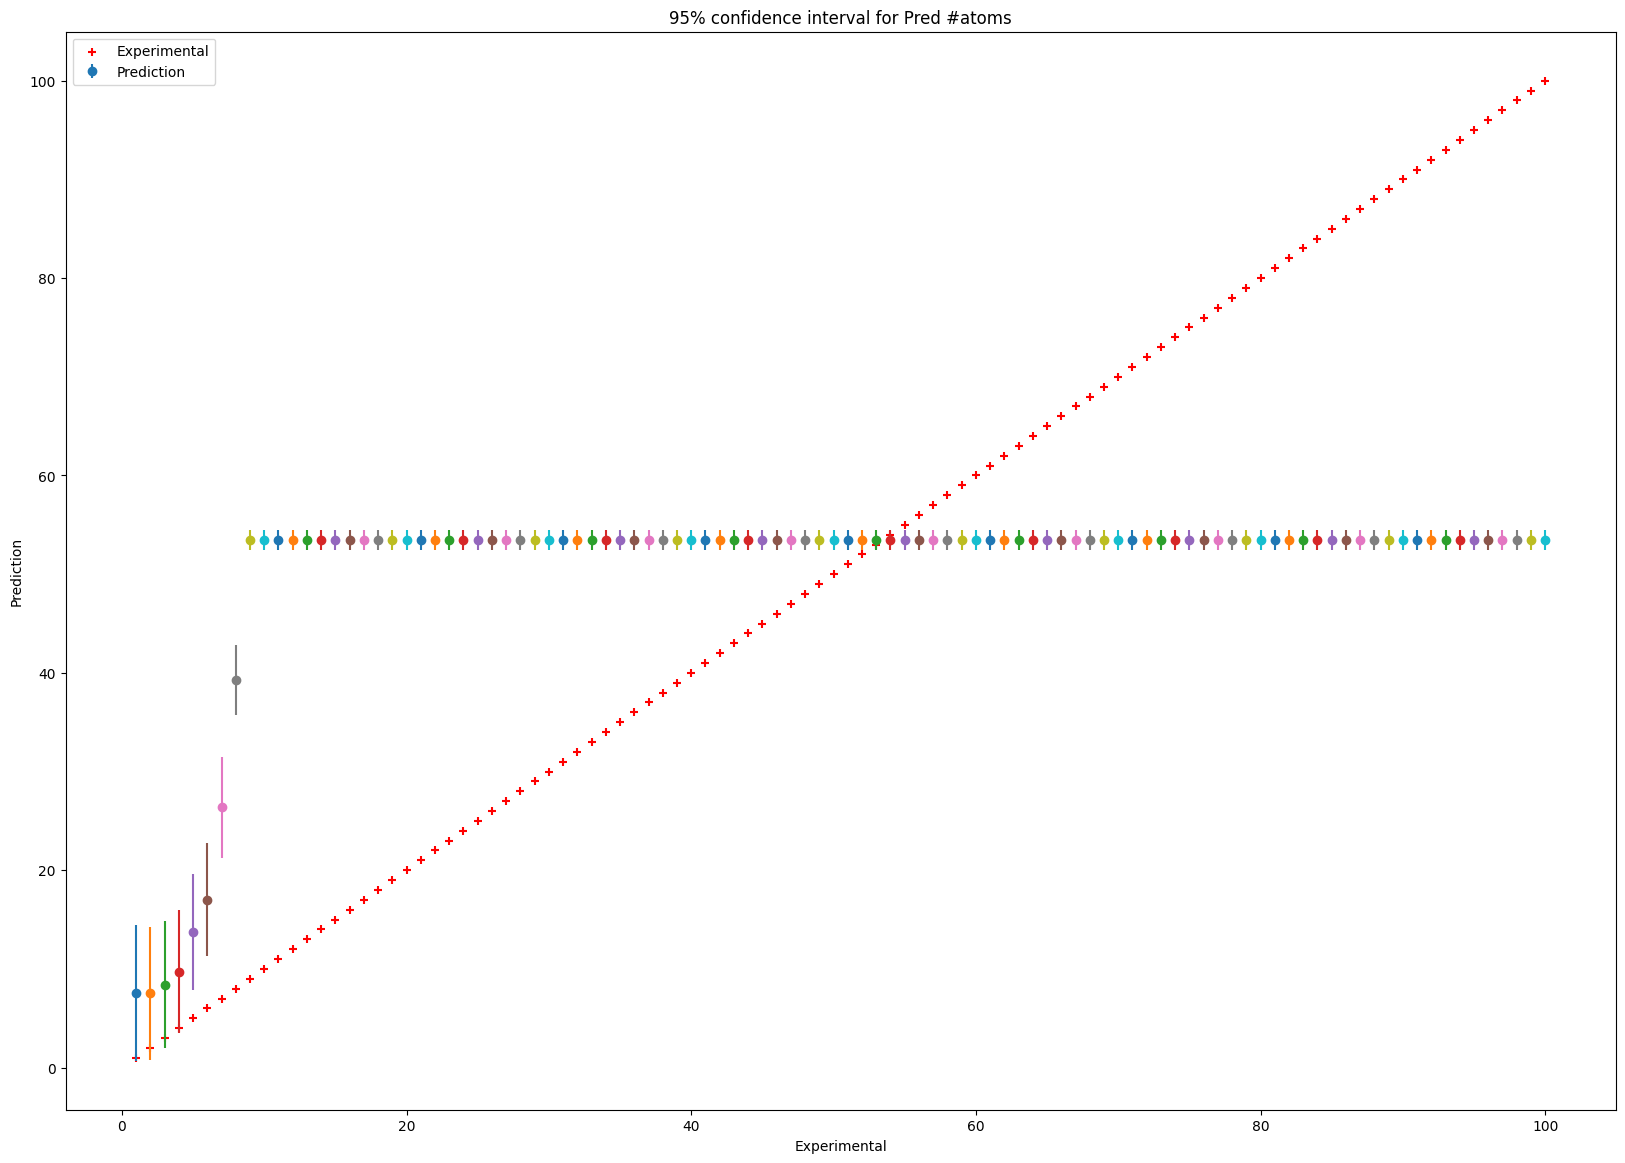

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(20,14))
for t,p,s in zip(Y, preds, errors):
    axs.errorbar(t, p, yerr=s, fmt='o')
axs.scatter(Y, Y, color='r', marker="+")
axs.set_title("95% confidence interval for Pred #atoms")
axs.set_xlabel("Experimental")
axs.set_ylabel("Prediction")
axs.legend(["Experimental", "Prediction"])

Adding RDKit Descriptors
=====================
We can also add RDKit descriptors by introducing a new kernel
Because we are using RDKit 2D features, this will actually work quite a bit better than fingerprints
for this particular prediction.

In [15]:
featgen = descriptors.MakeGenerator(["Morgan3", "RDKit2DNormalized"])
mols_processed, features = featgen.processSmiles(smiles)

/Users/bkelley/miniconda3/envs/test-ugm-talk/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6300: RuntimeWarning: overflow encountered in _ncf_cdf
  return _boost._ncf_cdf(x, dfn, dfd, nc)


**Note:** descriptastorus always includes a column indicating whether the molecule was processed or not.
    It is fine to keep this column, but since it will not be very predictive, let's remove it.
    
We can get the column names from the feature generator and look for the X_calculated bool column. 

In [16]:
featgen.columns[0:10], "...", featgen.columns[2049:2052]

([('Morgan3_calculated', bool),
  ('m3-0', numpy.uint8),
  ('m3-1', numpy.uint8),
  ('m3-2', numpy.uint8),
  ('m3-3', numpy.uint8),
  ('m3-4', numpy.uint8),
  ('m3-5', numpy.uint8),
  ('m3-6', numpy.uint8),
  ('m3-7', numpy.uint8),
  ('m3-8', numpy.uint8)],
 '...',
 [('RDKit2DNormalized_calculated', bool),
  ('BalabanJ', numpy.float64),
  ('BertzCT', numpy.float64)])

Use active_dims = slice(start, end+1) with the kernels to tell GPFlow what data to work on

In [17]:
kernel = Tanimoto(active_dims=slice(1,2049)) * gpflow.kernels.Matern52(active_dims=slice(2050, 2251))

In [18]:
fitter = TanimotoGP(kernel)
fitter.fit(features, list(range(1,101)))

In [19]:
preds, variances = fitter.predict(features)

In [20]:
errors = 1.96*(np.abs(variances)**0.5)

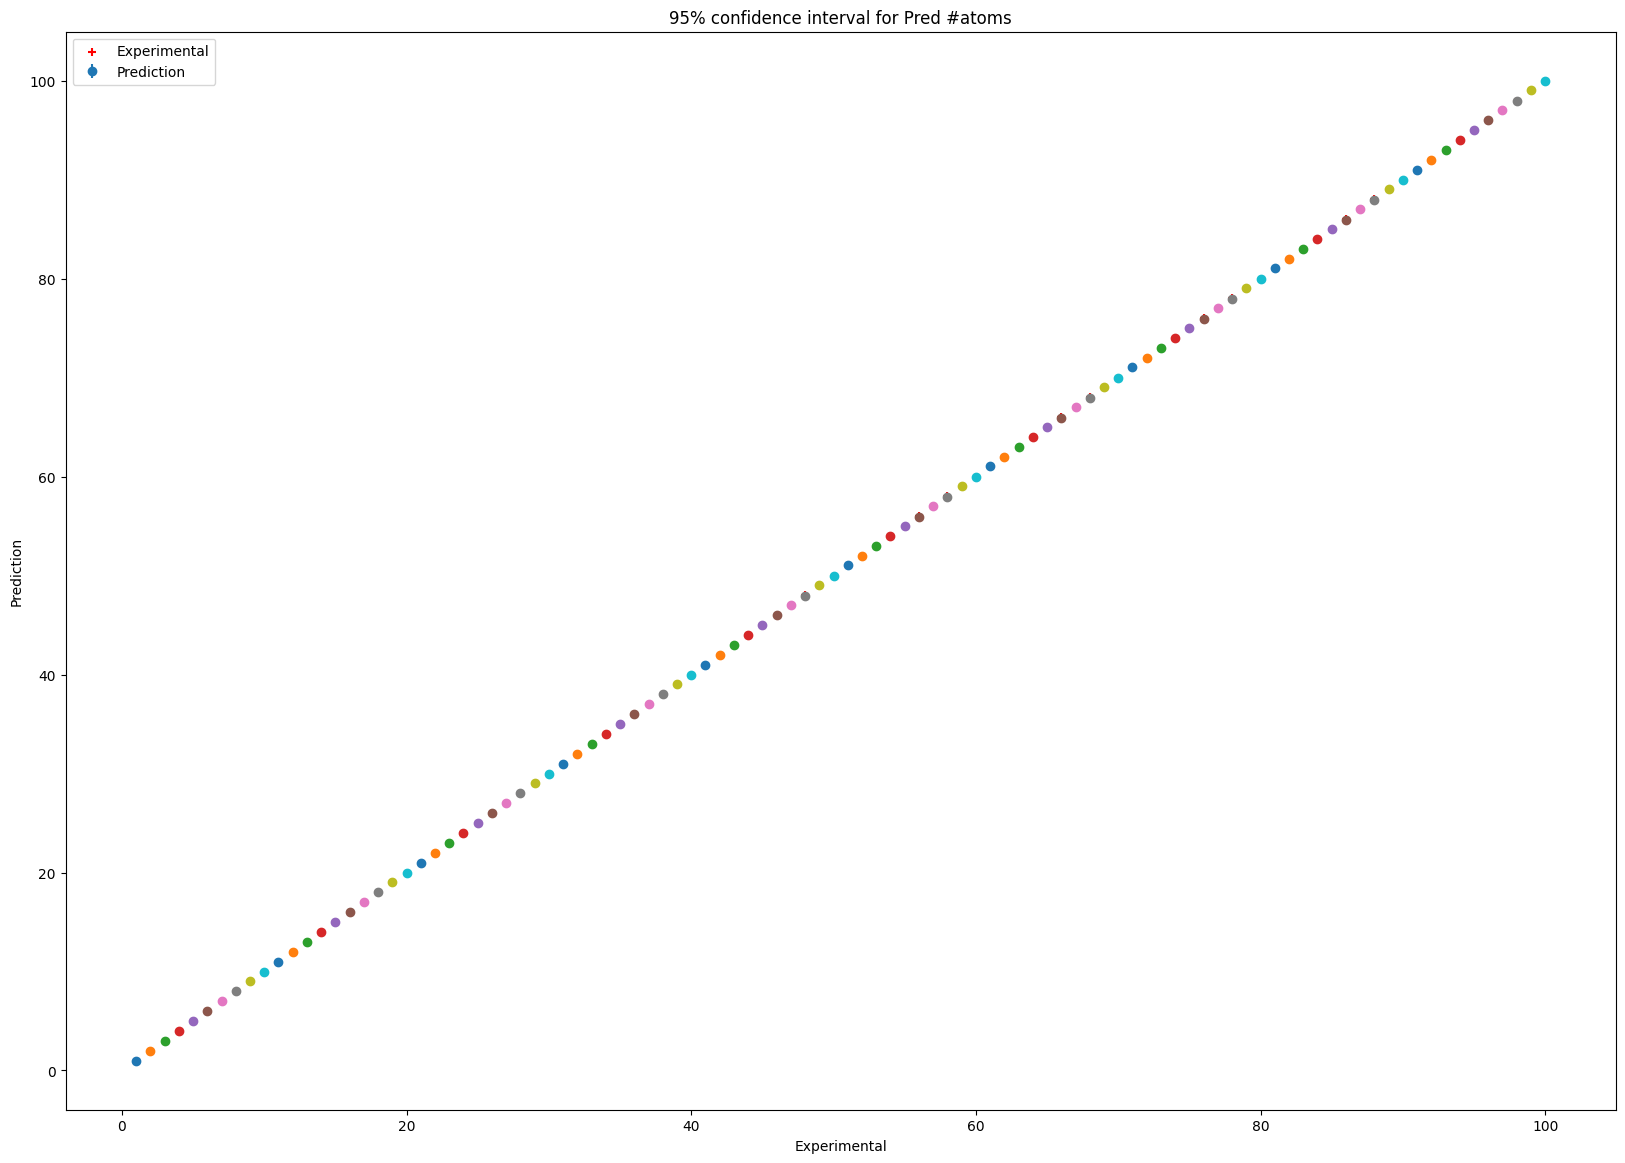

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(20,14))
for t,p,s in zip(Y, preds, errors):
    axs.errorbar(t, p, yerr=s, fmt='o')
axs.scatter(Y, Y, color='r', marker="+")
axs.set_title("95% confidence interval for Pred #atoms")
axs.set_xlabel("Experimental")
axs.set_ylabel("Prediction")
axs.legend(["Experimental", "Prediction"])

Of course, this is a bit of a cheat as one of the Descriptors is basically the number of heavy atoms.

Using Morgan Counts
===================

Instead of binary vectors, we can use morgan counts as well.

In [22]:
featgen = descriptors.MakeGenerator(["Morgan3Counts", "RDKit2DNormalized"])
mols_processed, features = featgen.processSmiles(smiles)

/Users/bkelley/miniconda3/envs/test-ugm-talk/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6300: RuntimeWarning: overflow encountered in _ncf_cdf
  return _boost._ncf_cdf(x, dfn, dfd, nc)


In [23]:
fitter = TanimotoGP()
fitter.fit(features, list(range(1,101)))

In [24]:
preds, variances = fitter.predict(features)

In [25]:
errors = 1.96*(np.abs(variances)**0.5)

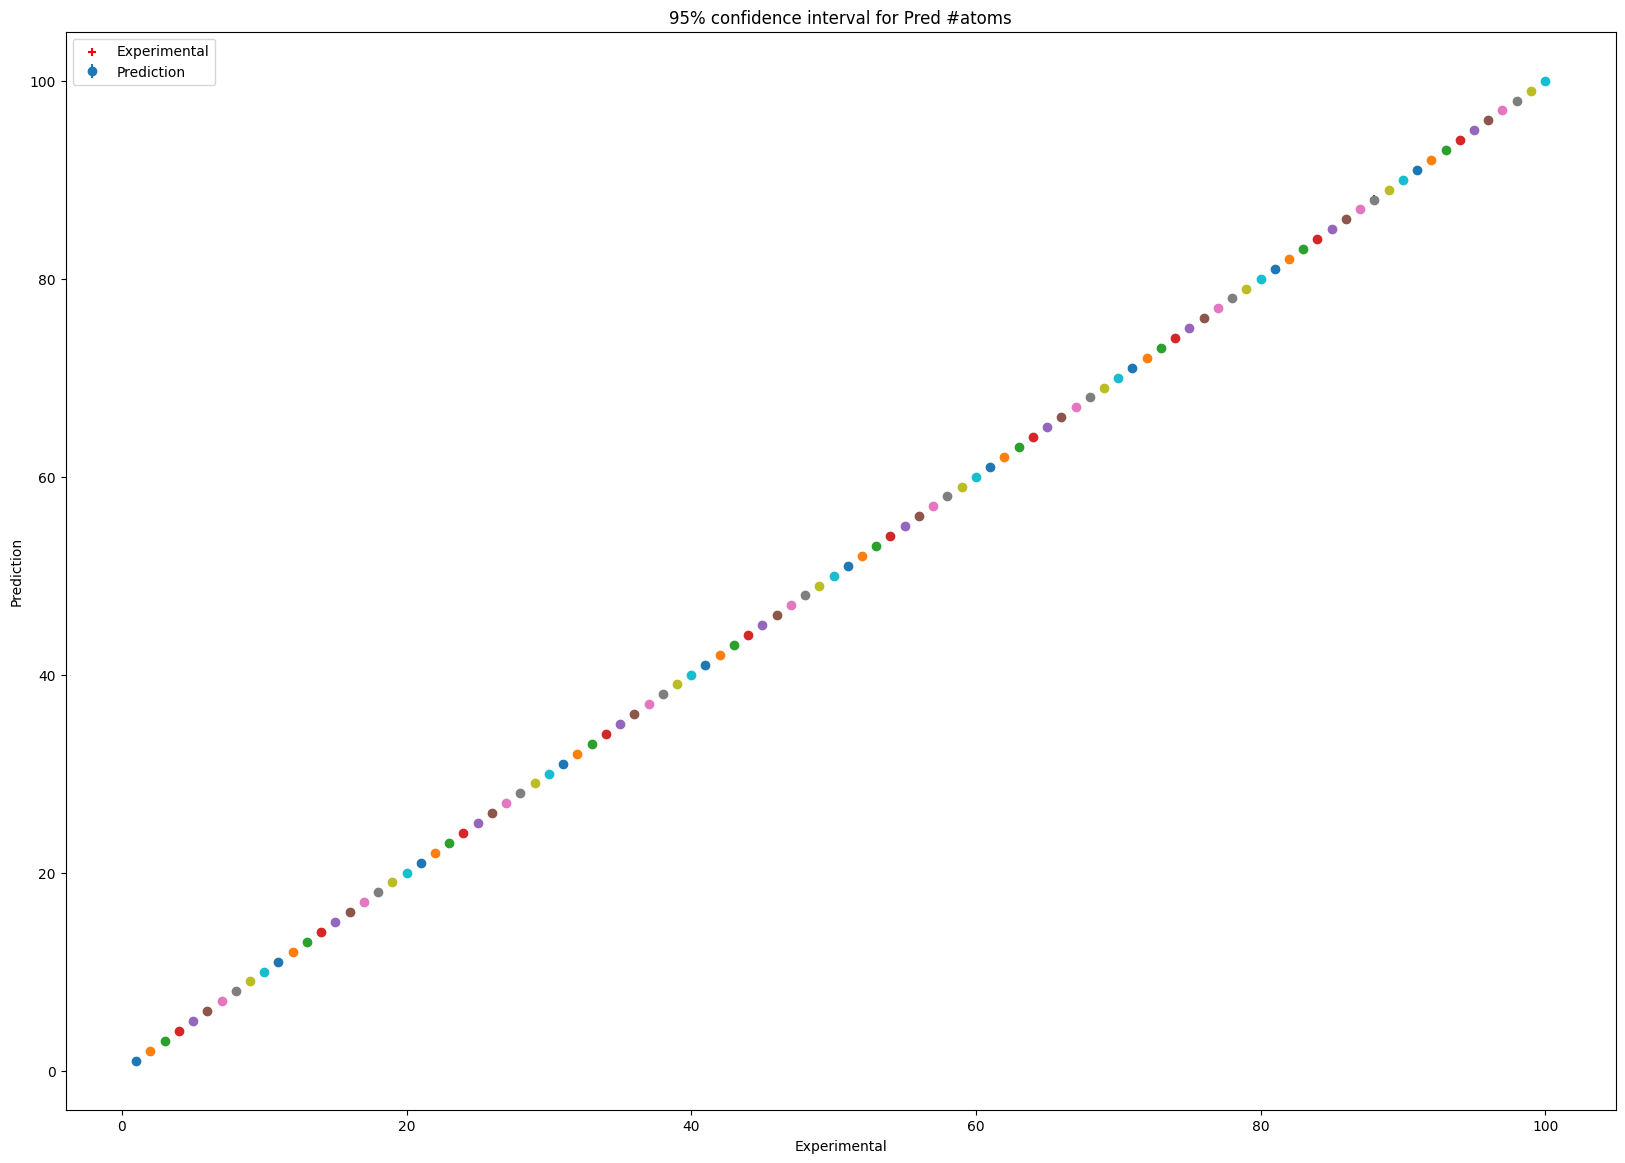

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(20,14))
for t,p,s in zip(Y, preds, errors):
    axs.errorbar(t, p, yerr=s, fmt='o')
axs.scatter(Y, Y, color='r', marker="+")
axs.set_title("95% confidence interval for Pred #atoms")
axs.set_xlabel("Experimental")
axs.set_ylabel("Prediction")
axs.legend(["Experimental", "Prediction"])

Unsurprisingly, morgan counts do quite a bit better than binary fingerprints for computing # heavy atoms.